In [2]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-20m.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-20m.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-20m"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

198702078/198702078 [==============================] - 3s 0us/step
Extracting all the files now...
Done!


In [4]:
ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [6]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 138493, Number of Movies: 26744, Min rating: 0.5, Max rating: 5.0


In [7]:
df = df.sample(frac=0.2, random_state=1006)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [34]:
min_rating

0.5

In [35]:
max_rating

5.0

In [11]:
EMBEDDING_SIZE = 100


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001))

In [12]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=512,
    epochs=8,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/8
7032/7032 [==============================] - 99s 14ms/step - loss: 0.0609 - val_loss: 0.0511
Epoch 2/8
7032/7032 [==============================] - 98s 14ms/step - loss: 0.0496 - val_loss: 0.0487
Epoch 3/8
7032/7032 [==============================] - 98s 14ms/step - loss: 0.0477 - val_loss: 0.0472
Epoch 4/8
7032/7032 [==============================] - 98s 14ms/step - loss: 0.0464 - val_loss: 0.0461
Epoch 5/8
7032/7032 [==============================] - 98s 14ms/step - loss: 0.0454 - val_loss: 0.0453
Epoch 6/8
7032/7032 [==============================] - 98s 14ms/step - loss: 0.0447 - val_loss: 0.0447
Epoch 7/8
7032/7032 [==============================] - 98s 14ms/step - loss: 0.0442 - val_loss: 0.0442
Epoch 8/8
7032/7032 [==============================] - 98s 14ms/step - loss: 0.0437 - val_loss: 0.0439


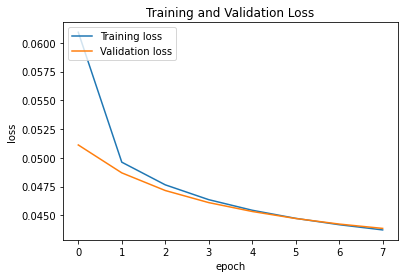

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Training loss", "Validation loss"], loc="upper left")
plt.show()

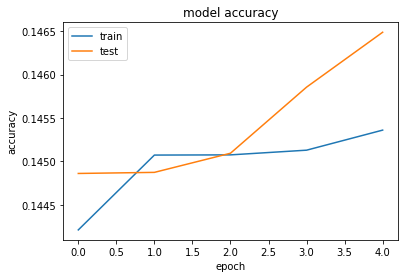

In [32]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [13]:
movie_DATA_FILE = 'movies.dat'
movie_df = pd.read_csv(os.path.join(movielens_dir, movie_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [20]:
movie_df.head()

,user_id,movie_id,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN
1,2,Jumanji (1995),Adventure|Children|Fantasy,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,NaN
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN
4,5,Father of the Bride Part II (1995),Comedy,NaN


In [14]:
df.head()

,userId,movieId,rating,timestamp,user,movie
4539168,31085,4306,4.0,1085416377,31084,119
14405130,99512,2951,3.0,997208898,99511,207
12649350,87427,3770,4.5,1178434240,87426,2456
19644866,136001,5374,1.0,1261941506,136000,8557
12579811,86898,235,2.0,974734146,86897,394


In [16]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

834/834 [==============================] - 1s 2ms/step
Showing recommendations for user: 67064
Movies with high ratings from user
--------------------------------
Twelve Monkeys (a.k.a. 12 Monkeys) (1995) : Mystery|Sci-Fi|Thriller
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
Good Will Hunting (1997) : Drama|Romance
Moulin Rouge (2001) : Drama|Musical|Romance
--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Schindler's List (1993) : Drama|War
Godfather, The (1972) : Crime|Drama
Casablanca (1942) : Drama|Romance
One Flew Over the Cuckoo's Nest (1975) : Drama
Godfather: Part II, The (1974) : Crime|Drama
Fight Club (1999) : Action|Crime|Drama|Thriller
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) : Comedy|Romance
City of God (Cidade de Deus) (2